# Simple object localisation with MNIST

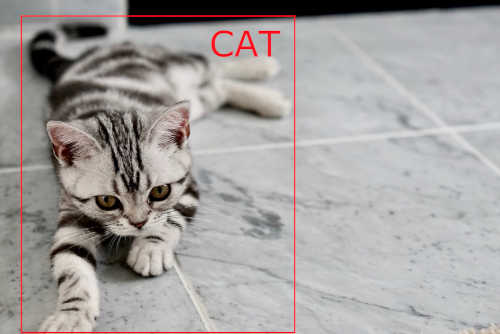

In this notebook we will build a single object classification + localization network. For the sake of simplicity and prompt training, we will play around the the MNIST dataset and make an object-localization problem with it.

In [1]:
import torch
from torchvision.datasets import MNIST
import numpy as np
import PIL
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import multiprocessing
from IPython.display import clear_output
from scipy import fft

device = (
    torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
)
device

device(type='cpu')

In [2]:
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning
                            # installed by default.
                            # Hence, we do it here if necessary
    !pip install pytorch-lightning==1.3.4
    import pytorch_lightning as pl

We will create our object-localization problem by taking large empty images and putting MNIST digit images on top of them, a single digit per image. We will also add some noize to make this task a bit more challenging.

In [3]:
# Creating our modified-MNIST dataset
class ModifiedMNIST(MNIST):
    def __init__(
        self,
        *argv,
        size=(128, 128),
        rotations=(-15, 15),
        seed=42,
        **kwargs,
    ):
        super().__init__(*argv, **kwargs)
        self.size = size

        # random rotations and positionings of the MNIST digits on our empty images
        np.random.seed(seed)
        self.rotations = np.random.uniform(*rotations, size=len(self))
        self.v_offsets = np.random.uniform(size=len(self))
        self.h_offsets = np.random.uniform(size=len(self))

        # width and height of a rotated 28x28 square:
        self.content_widths = np.ceil(
            (28 * 2**0.5) * np.maximum(
                np.abs(np.sin(self.rotations / 180. * np.pi + np.pi / 4)),
                np.abs(np.sin(self.rotations / 180. * np.pi - np.pi / 4))
            )
        )
        self.content_heights = self.content_widths

        # Now that we know the full image size and content size, we can convert our
        # coordinates from [0-1] scale to pixels
        self.v_offsets = np.floor(
            self.v_offsets * (self.size[0] - self.content_heights)
        ).astype(int)
        self.h_offsets = np.floor(
            self.h_offsets * (self.size[1] - self.content_widths)
        ).astype(int)

        assert (self.v_offsets >= 0).all()
        assert (self.h_offsets >= 0).all()

    def __getitem__(self, idx):
        img, label = super().__getitem__(idx) # get an MNIST image

        # get the location and rotation
        h_offset = self.h_offsets[idx]
        v_offset = self.v_offsets[idx]
        angle = self.rotations[idx]

        # rotate the image
        img = np.array(img.rotate(angle, expand=True, resample=PIL.Image.BICUBIC))

        # build a clean image without any noize
        result_img = np.zeros(shape=self.size, dtype=img.dtype)
        result_img[v_offset : v_offset + img.shape[0],
                   h_offset : h_offset + img.shape[1]] = img
        # and find the bounding box for the MNIST digit:
        nonzero_coords = np.nonzero(result_img > 0.5)
        xmin = np.min(nonzero_coords[1])
        xmax = np.max(nonzero_coords[1]) + 1
        ymin = np.min(nonzero_coords[0])
        ymax = np.max(nonzero_coords[0]) + 1
        box = torch.tensor([
            xmin / self.size[1],
            ymin / self.size[0],
            xmax / self.size[1],
            ymax / self.size[0],
        ]).to(torch.float32)

        # build a noizy image
        result_img = np.zeros(shape=self.size, dtype=img.dtype)
        result_fft = fft.rfft2(result_img)
        result_fft += np.random.normal(size=result_fft.shape) * 150
        result_img = fft.irfft2(result_fft).astype(img.dtype)
  
        result_img[v_offset : v_offset + img.shape[0],
                   h_offset : h_offset + img.shape[1]] += img
        result_img = np.clip(result_img, 0, 255)

        result_img = torch.tensor(result_img / 255).to(torch.float32)
        return result_img, dict(
            label=torch.tensor(label),
            box=box
        )

In [4]:
# Create our dataset instances
ds_train = ModifiedMNIST(".", train=True, download=True)
ds_test = ModifiedMNIST(".", train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .\ModifiedMNIST\raw\train-images-idx3-ubyte.gz to .\ModifiedMNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .\ModifiedMNIST\raw\train-labels-idx1-ubyte.gz to .\ModifiedMNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .\ModifiedMNIST\raw\t10k-images-idx3-ubyte.gz to .\ModifiedMNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .\ModifiedMNIST\raw\t10k-labels-idx1-ubyte.gz to .\ModifiedMNIST\raw



OK, let's have a look at some of the images that we've created.

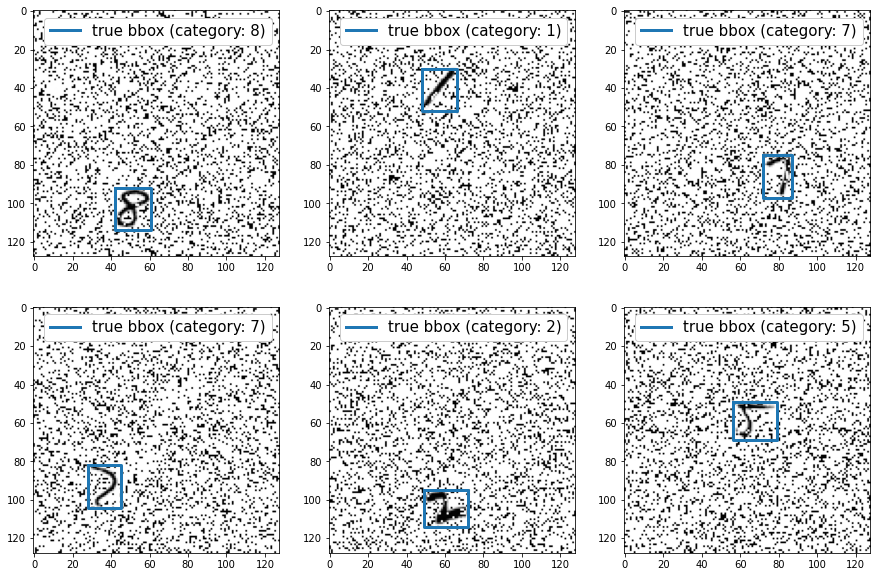

In [5]:
def draw_image(image, meta):
    img = image.numpy()

    xmin, ymin, xmax, ymax = meta["box"].numpy() * 128

    plt.imshow((img * 255).astype("uint8"), cmap='Greys')
    plt.plot(
        [xmin, xmax, xmax, xmin, xmin],
        [ymin, ymin, ymax, ymax, ymin],
        label=f'true bbox (category: {meta["label"].numpy()})',
        linewidth=3,
    )
    plt.legend(fontsize=15, framealpha=1.0)

plt.figure(figsize=(15, 10))

np.random.seed(32476)
for i_subfig, i_img in enumerate(np.random.randint(len(ds_train), size=6), 1):
    plt.subplot(2, 3, i_subfig)
    draw_image(*ds_train[i_img])

The task for our network will be to classify and locate the digits. To do that, we'll create a convolutional neural network and add two heads to it: one for classification, another for regressing on the bounding box coordinates.

In [6]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_backbone = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, 3, padding=1, bias=False), # 1x128x128 --> 8x128x128
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),

            torch.nn.Conv2d(8, 8, 3, padding=1, bias=False), # --> 8x128x128
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),

            torch.nn.MaxPool2d(2), # --> 8x64x64

            torch.nn.Conv2d(8, 16, 3, padding=1, bias=False), # --> 16x64x64
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),

            torch.nn.Conv2d(16, 16, 3, padding=1, bias=False), # --> 16x64x64
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),

            torch.nn.MaxPool2d(2), # --> 16x32x32

            torch.nn.Conv2d(16, 32, 3, padding=1, bias=False), # --> 32x32x32
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),

            torch.nn.Conv2d(32, 32, 3, padding=1, bias=False), # --> 32x32x32
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),

            torch.nn.MaxPool2d(2), # --> 32x16x16

            torch.nn.Conv2d(32, 32, 3, padding=1, bias=False), # --> 32x16x16
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),

            torch.nn.MaxPool2d(2), # --> 32x8x8

            torch.nn.Conv2d(32, 32, 3, padding=1, bias=False), # --> 32x8x8
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),

            torch.nn.MaxPool2d(2), # --> 32x4x4

            torch.nn.Flatten(),
        )
        self.classifier_head = torch.nn.Sequential(
            torch.nn.Linear(32 * 4 * 4, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10),
        )
        self.regressor_head = torch.nn.Sequential(
            torch.nn.Linear(32 * 4 * 4, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 4),
        )

    def forward(self, x):
        features = self.conv_backbone(torch.unsqueeze(x, 1))
        logits = self.classifier_head(features)
        bbox = self.regressor_head(features)
        return logits, bbox


### Task 1 (2 points)

Let's wrap our model within a lightning module. Your task will be to implement the calculation of the loss function. Note, that the loss function consists of the two components: regressor and classifier losses.

We will use simple MSE for the regressor's loss:
$$L_{\text{regressor}}=\left<\left(y_{\text{true}}-y_{\text{pred}}\right)^2\right>,$$
where $y_{\text{true}}$ and $y_{\text{pred}}$ are the tensors containing the ground truth and predicted bounding box coordinates, respectively, and averaging $\left<\cdot\right>$ is taken over the 4 coordinates of the bounding box and over all the images in the batch, simultaneously. This loss can be coded directly using the available ground truth and prediction tensors.

As for the classifier's loss, we'll use the cross-entropy loss (which is the same as negative log-likelihood). Note that this function is pre-implemented in torch. There's actually two slightly different versions:
- [torch.nn.functional.cross_entropy](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html)
- [torch.nn.functional.nll_loss](https://pytorch.org/docs/stable/generated/torch.nn.functional.nll_loss.html)

Which of the two is suitable for our case?

In [13]:
import torch
from torch import nn
from torch.nn import functional as F

In [8]:
class LitModel(pl.LightningModule):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.model = Model()

    def forward(self, x):
        assert not self.model.training
        return self.model(x)

    # We nee to calculate losses in both LitModel.training_step()
    # and LitModel.validation_step(). To avoid unnecessary copy-pasting
    # of the code, we'll do the calculation of the loss values
    # in this LitModel._shared_losses_calculation() method which
    # will be called by both the *_step() methods mentioned above.
    def _shared_losses_calculation(self, batch):
        """Calculate the loss value on a given batch"""

        # Due to how we implemented the ModifiedMNIST class,
        # the data will be provided as tuples of the following
        # form: (image_tensor, metadata_dict). The metadata dictionary
        # contains two records: "label" (an integer, representing the category
        # of the digit), and "box" (a tensor with bounding box coordinates).
        # So let's retrieve those:
        batch_img, batch_meta = batch

        # Now it's your turn:
        #  - make the forward pass through the model
        #  - calculate classifier_loss - the loss of the classifier head (cross entropy)
        #  - calculate regressor_loss - the loss of the regressor head (MSE)

        # <YOUR CODE> (forward pass)
        classifier_loss = nn.CrossEntropyLoss()
        regressor_loss = nn.MSE_loss()

        # The total loss is a weighted combination of the two loss components
        # (we've tuned the weights for some reasonable results, but feel free
        # to experiment with different weights)
        loss = 0.1 * classifier_loss + regressor_loss
        return classifier_loss, regressor_loss, loss

    def training_step(self, batch, batch_idx):
        assert self.model.training
        classifier_loss, regressor_loss, loss = (
            self._shared_losses_calculation(batch)
        )
        self.log("train_classifier_loss", classifier_loss)
        self.log("train_regressor_loss", regressor_loss)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        assert not self.model.training
        classifier_loss, regressor_loss, loss = (
            self._shared_losses_calculation(batch)
        )
        self.log("validation_classifier_loss", classifier_loss)
        self.log("validation_regressor_loss", regressor_loss)
        self.log("validation_loss", loss)
        return loss

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters())
        return opt


Creating a model instance and the data loaders:

In [10]:
model = LitModel()

train_loader = torch.utils.data.DataLoader(
    ds_train,
    batch_size=256,
    shuffle=True,
    num_workers=multiprocessing.cpu_count(),
)
test_loader = torch.utils.data.DataLoader(
    ds_test, batch_size=2048
)

trainer = pl.Trainer(
     max_epochs=3, log_every_n_steps=5, flush_logs_every_n_steps=10
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
c:\users\chere\appdata\local\programs\python\python39\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:59: LightningDeprecationWarning: Setting `Trainer(flush_logs_every_n_steps=10)` is deprecated in v1.5 and will be removed in v1.7. Please configure flushing in the logger instead.
  rank_zero_deprecation(


In [11]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

OK, now it's time to train our network!

In [14]:
trainer.fit(model, train_loader, test_loader)


  | Name  | Type  | Params
--------------------------------
0 | model | Model | 169 K 
--------------------------------
169 K     Trainable params
0         Non-trainable params
169 K     Total params
0.679     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:76] data. DefaultCPUAllocator: not enough memory: you tried to allocate 134217728 bytes.

In [ ]:
# Let's take predictions on a single test batch
test_batch_img, test_batch_meta = next(iter(test_loader))
model.eval()
with torch.autograd.no_grad():
    test_pred_logits, test_pred_bbox = model.to(device)(test_batch_img.to(device))
    test_pred_logits = test_pred_logits.cpu().numpy()
    test_pred_bbox = test_pred_bbox.cpu().numpy()

In [ ]:
def draw_image(i):
    img = test_batch_img[i].numpy()
    pred_category = test_pred_logits[i].argmax()
    xmin, ymin, xmax, ymax = test_batch_meta["box"][i].numpy() * 128 
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = test_pred_bbox[i] * 128

    plt.imshow((img * 255).astype("uint8"), cmap='Greys')

    plt.plot(
        [xmin, xmax, xmax, xmin, xmin],
        [ymin, ymin, ymax, ymax, ymin],
        label=f'true ({test_batch_meta["label"][i]})',
        linewidth=3,
    )
    plt.plot(
        [xmin_pred, xmax_pred, xmax_pred, xmin_pred, xmin_pred],
        [ymin_pred, ymin_pred, ymax_pred, ymax_pred, ymin_pred],
        label=f'pred ({pred_category})',
        linewidth=3,
    )
    plt.legend(fontsize=12, framealpha=1.0)

plt.figure(figsize=(15, 10))
np.random.seed(2489)
for i_subfig, i_img in enumerate(np.random.randint(len(test_batch_img), size=6), 1):
  plt.subplot(2, 3, i_subfig)
  draw_image(i_img)